In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyldavis==3.2.2

# Ler e analisar os dados

In [72]:
import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/drive/MyDrive/MELI/data/dados.csv', sep=',')
df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   a       150000 non-null  int64  
 1   b       137016 non-null  float64
 2   c       137016 non-null  float64
 3   d       149635 non-null  float64
 4   e       150000 non-null  float64
 5   f       149989 non-null  float64
 6   g       149806 non-null  object 
 7   h       150000 non-null  int64  
 8   i       150000 non-null  object 
 9   j       150000 non-null  object 
 10  k       150000 non-null  float64
 11  l       149989 non-null  float64
 12  m       149635 non-null  float64
 13  n       150000 non-null  int64  
 14  o       41143 non-null   object 
 15  p       150000 non-null  object 
 16  fecha   150000 non-null  object 
 17  monto   150000 non-null  float64
 18  score   150000 non-null  int64  
 19  fraude  150000 non-null  int64  
dtypes: float64(9), int64(5), object(6)
memory usage:

A coluna `Score` corresponde ao resultado do algoritmo a ser substituído.  
**Dominio**:
- valor entre 0 e 100
- 0 (zero) é o risco mais baixo
- 100 (cem) o mais alto

In [53]:
target_name = "fraude"
old_res = "score"

In [ ]:
print(df[target_name].unique())

print(sum(df[target_name] == 1))

print(sum(df[target_name] == 0))

[0 1]
7500
142500


Tem quase **20** vezes menos fraudes do que de transaçoes validas.  
Ou seja, o dataset é bem desbalanceado.  
Tentaremos lidar com isso mais pra frente.



# Extrair informaçoes das variaveis

Antes de visualizarmos as contribuiçoes das nossas variaveis de texto, vamos precisar realizar algumas transformaçoes nelas.

## Artigos da transaçao

Caso as transaçoes acontecem via site de `e-commerce`, 
- entao a maior parte das fraudes costumam involver o **usurpo de identidade**. Pode ser o roubo fisico do cartao de credito, o roubo das informaçoes do cartao de credito, etc.
- Costumam tambem ser casos de **friendly fraud**.
  - Compras com o cartão e, em seguida, solicitar um estorno, dizendo que os detalhes do cartão de crédito foram roubados.

- Nestes 2 casos, o artigo comprado costuma ter um valor alto.  
- Podemos tambem imaginar que para tentar evitar ser pego, o fraudador realiza compras de valores mais baixos mas de artigos que podem ser revendidos facilmente, como cabos de celular, fones de ouvido, etc.  

Em ambos os casos, deveriamos poder identificar algum padrao de compra mais suscetivel de ser associado a uma transaçao fraudulente. 

In [ ]:
for i in range(10):
  print(df.loc[i, 'i'])

Máquininha Corta Barba Cabelo Peito Perna Pelos Pézinho Nova
Avental Descartavel Manga Longa  - 50 Un. Tnt Hospitalar 40g
Bicicleta Mountain Fire Bird Rodado 29 Aluminio Shimano 21v
Caneta Delineador Carimbo Olho Gatinho Longo 2 Em 1 Tango
Resident Evil Operation Raccoon City Ps3
Kit Gamer Teclado Hedfone Mouse E Mousepad
Corpinho Avulso Joseph, Josepha Ou Placa Sem Sexo
Tripa Para Fazer Linguiça - 45 Metros Long Short
Soldadora Inverter 180 A + Máscara + 2 Esc. Mag 4´ Kroner
Gamepad Joystick Para Telefono Celular Android Bluetooth Cuo


In [ ]:
pd.set_option('display.max_colwidth', None)

df.loc[df[target_name] == 1, 'i'].head()

16                                          Chaveiro Lindo Do Thor
45                                    Teclado Macbook Pro A1278 Us
69    Bota Masculina Coturno Venetto Couro Legítimo Urbano Moderno
81    Álcool Gel 70% Antisséptico -1 Gl 5 Lt.=140,00àvista.transf.
87                         Pneu Cooper Classic Tour 185/65 R14 86t
Name: i, dtype: object

In [ ]:
df.loc[df[target_name] == 1, 'i'].tail()

149931        Combo Kit Nutri Whey + Creatina + Coqueteleira + Brindes
149948    100 Un Luva De Procedimento Descartável Vinil C/ Pó Envio Já
149958              Kit Borrachinha Aparelho Ortodôntico Personalizado
149964             (par) Friso Cromo Polo Virtus Original 6ea8537682zz
149985          Silla Ejecutiva Miles Con Masajes Premium Super Oferta
Name: i, dtype: object

- A primeira vista, nao parece ter um padrao de compra especifico associado a uma transaçao fraudulente.
- Porem, antes de descartar essa variavel de descriçao de compra, vamos realizar uma analise mais profunda.
  - Vamos utilizar o algoritmo **Latent Dirichlet Allocation** para clusterizar as nossas descriçoes em categorias de compra,
  - e veremos se conseguimos enxergar uma tendencia de fraude maior em certas dessas categorias.

### Preparaçao dos dados de texto

In [ ]:
# Download NLT required data packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')
nltk.download('wordnet')
nltk.download('rslp')

# Import nltk packages and string 
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
# Define stopwords to exclude
stop = set(stopwords.words('portuguese'))
stop.update(('x'))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

In [ ]:
# Cleaning the text
# NLTK includes the RSLP Portuguese stemmer
from nltk.stem import RSLPStemmer
stemmer = RSLPStemmer()
# Define word cleaning function
def clean(text, stop):
    text = text.rstrip()
    # Remove stopwords
    stop_free = " ".join([word for word in text.lower().split() if ((word not in stop) and (not word.isdigit()))])
    # Remove punctuations
    punc_free = ''.join(word for word in stop_free if word not in exclude)
    # Stem all words
    cleaned_text = " ".join(stemmer.stem(word) for word in punc_free.split())      
    return cleaned_text

In [ ]:
# Clean the purchases in df and print results
text_clean=[]
for text in df['i']:
    text_clean.append(clean(text, stop).split())    
print(text_clean[:10])

[['máquin', 'cort', 'barb', 'cabel', 'peit', 'pern', 'pé', 'nov'], ['avent', 'descarta', 'mang', 'long', 'un', 'tnt', 'hospital', '40g'], ['biciclet', 'mountain', 'fir', 'bird', 'rod', 'alumini', 'shim', '21v'], ['canet', 'deline', 'carimb', 'olh', 'gat', 'long', 'tang'], ['resident', 'evil', 'operation', 'raccoon', 'city', 'ps3'], ['kit', 'gam', 'tecl', 'hedfon', 'mous', 'mousepad'], ['corp', 'avuls', 'joseph', 'joseph', 'plac', 'sex'], ['trip', 'faz', 'linguiç', 'metr', 'long', 'short'], ['sold', 'invert', 'másc', 'esc', 'mag', '4´', 'kron'], ['gamepad', 'joystick', 'telefon', 'celul', 'android', 'bluetooth', 'cuo']]


In [ ]:
import gensim
from gensim import corpora

# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# filter out words that appear in less than 5 purchase descriptions
# and keep only the 50000 most frequent words, in a way of cleaning out the outlier noise of the text data
dictionary.filter_extremes(no_below=5, keep_n=50000)
# Define the corpus
corpus = [dictionary.doc2bow(text) for text in text_clean]

In [ ]:
# Print corpus and dictionary
print(corpus[:10]) # bag of words
print(dictionary)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)], [(12, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(30, 1), (31, 1), (32, 1), (33, 1)], [(34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(39, 1), (40, 1), (41, 2), (42, 1), (43, 1)], [(12, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)], [(49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)], [(55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)]]
Dictionary(15696 unique tokens: ['barb', 'cabel', 'cort', 'máquin', 'nov']...)


### Clusterizaçao em topicos

- Vamos primeiro executar o **LDA** com um numero alto de topicos, **20**, para segmentar mais finamente e favorecer o destaque de topicos de tamanhos menores (outliers), sucetiveis de corresponder a transaçoes potencialmente fraudulentes
- Caso for concluente, entao tentaremos diminuir o numero de topicos para conseguirmos uma interpretaçao mais intuitiva do sentido de cada topico e eventualmente associa-lo a uma categoria de compra.

In [ ]:
import logging
# enable logging
logging.basicConfig(filename='gensim.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

num_topics = 20
chunksize = 2000
passes = 20
iterations = 400

# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, passes=passes, eval_every=1)
# DEBUG : 2000/2000 documents converged within 50 iterations
# convergence: convergence to one topic during inference of topic distribution on a document

In [ ]:
ldamodel.save("ldamodel.gensim")
# ldamodel = gensim.models.ldamodel.LdaModel.load("ldamodel.gensim")

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


### Analise dos topicos

In [ ]:
# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.041*"con" + 0.034*"y" + 0.025*"mes" + 0.022*"cm" + 0.019*"comb"')
(1, '0.025*"par" + 0.025*"kit" + 0.024*"tras" + 0.022*"gol" + 0.022*"tamp"')
(2, '0.030*"tel" + 0.025*"kg" + 0.022*"cart" + 0.022*"carr" + 0.018*"mot"')
(3, '0.020*"filtr" + 0.020*"tip" + 0.018*"natur" + 0.015*"con" + 0.014*"carg"')
(4, '0.025*"disc" + 0.020*"man" + 0.018*"pared" + 0.017*"águ" + 0.017*"chav"')
(5, '0.059*"led" + 0.034*"tv" + 0.020*"tecl" + 0.020*"smart" + 0.019*"luz"')
(6, '0.030*"digit" + 0.023*"feminin" + 0.021*"masculin" + 0.018*"ps3" + 0.018*"red"')
(7, '0.034*"bols" + 0.025*"n95" + 0.024*"nov" + 0.021*"pff2" + 0.019*"mochil"')
(8, '0.045*"branc" + 0.040*"envi" + 0.040*"kit" + 0.020*"led" + 0.016*"ades"')
(9, '0.054*"kit" + 0.045*"infantil" + 0.022*"entreg" + 0.021*"atac" + 0.020*"pront"')
(10, '0.035*"model" + 0.030*"fret" + 0.022*"grátil" + 0.020*"kit" + 0.019*"tapet"')
(11, '0.037*"bluetooth" + 0.028*"fio" + 0.027*"gam" + 0.027*"fon" + 0.025*"pc"')
(12, '0.036*"complet" + 0.032*"kit" + 0.02

Com 20 topicos, fica dificil interpretar do que se tratam. Parece ter varias topicos involvendo produtos eletronicos, sem podermos fazer nenhuma hipotese de qual a especifidade de cada um.

In [ ]:
def get_topic_details(ldamodel, corpus):
  topic_details_df = pd.DataFrame()
  for i, row in enumerate(ldamodel[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0: # => dominant topic
        wp = ldamodel.show_topic(topic_num)
        topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]),
                                                   ignore_index=True)
  topic_details_df.columns = ["Dominant_Topic", "% Score"]
  return topic_details_df

Vamos utilizar essa funçao `get_topic_details` para gerar o `DataFrame` com
- o número do tópico dominante
- a pontuação de probabilidade com esse tópico
- os dados do texto original

In [ ]:
contents = pd.DataFrame({"Original Text": text_clean})
# 10 minutes
topic_details = pd.concat([get_topic_details(ldamodel,
                                             corpus), contents], axis=1)
topic_details.head()

,Dominant_Topic,% Score,Original Text
0,5.0,0.557357,"[máquin, cort, barb, cabel, peit, pern, pé, nov]"
1,13.0,0.672222,"[avent, descarta, mang, long, un, tnt, hospital, 40g]"
2,2.0,0.722035,"[biciclet, mountain, fir, bird, rod, alumini, shim, 21v]"
3,18.0,0.506250,"[canet, deline, carimb, olh, gat, long, tang]"
4,6.0,0.610000,"[resident, evil, operation, raccoon, city, ps3]"


In [ ]:
topic_details.to_csv("topic_details.csv", index=False)
# topic_details = pd.read_csv("topic_details.csv")
# topic_details.head()

Podemos visualizar os clusters com a biblioteca `pyLDAvis`.  
- Quanto maior a bolha, mais prevalente será o tópico. 
- Um bom modelo de tópico terá bolhas bastante grandes e não sobrepostas espalhadas pelo gráfico 

In [ ]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus,
                                      dictionary, sort_topics=False)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
pyLDAvis.display(lda_display)

Nao parece ter um topico bem menos prevalente (outliers potenciais) que poderia ser associado a um topico de descriçao de compra mais sucetivel a fraude.

Vamos visualizar a proporçao de fraudes em cada um dos topicos. 

In [ ]:
topic_details_frauds = pd.concat([topic_details, df[target_name]], axis=1)
topic_details_frauds.head()

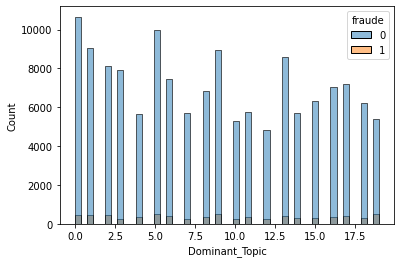

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(x="Dominant_Topic", data=topic_details_frauds, hue=target_name, bins=50)
plt.show()

A distribuiçao de fraudes entre os topicos parece bem homogênea. Nao tem uma categoria semantica de descriçao de compra mais representativa de transaçoes fraudulentes. Ou seja  
- os tipos de fraudes podem ser completamente diferente daqueles sugeridos na nossa hipotese inicial (site e-commerce com pagamento no cartao).
  - Como nao temos conhecimento de qual o canal de compra, da forma de pagamento, fica dificil emitir outras hipoteses.
- Pode ser que o **LDA** nao seja o metodo o mais adequado neste caso. Com os conhecimentos e a experiencia dos analistas de fraude da empresa, poderiamos talvez associar as descriçoes de compra a categorias de compra que os analistas mapearam.
- Podemos tambem imaginar que essa coluna esteja com dados mocados e entao as descriçoes de compra nao correspondem as transaçoes efetuadas.

Nas proximas etapas, vamos desconsiderar essa variavel `i` de compra efetuada.

In [73]:
df.drop(['i'], axis=1, inplace=True)

## Data de transaçao

In [74]:
df.loc[:, "date"] = df["fecha"].str.split().apply(lambda x: x[0])
df.loc[:, "time"] = df["fecha"].str.split().apply(lambda x: x[1])

In [75]:
import gc

l = sorted(df["date"].unique())
print(l[:5])
print(l[-5:])
del l
gc.collect()

['2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12']
['2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21']


55

Temos 2 meses de transaçoes: março e abril de 2020.  
- Nao aconteceu nenhum evento especifico nesse intervalo que permitiria adicionar uma flag na base de treinamento. 
  - Estavamos no periodo de pandemia ja e a quantidade de transaçoes online ja estava alta.

Porem podemos extrair outras informaçoes uteis como
- **Inicio** e **fim do mes**
  - Nesses periodos, o salario costuma cair na conta do usuario. Seria o momento ideal para fraudar com um cartao roubado por exemplo.
- O **dia da semana**
  - Os usuarios lambdas podem ter padroes de compra semanais. Mais tempo no fim de semana para comprar online por exemplo.

In [76]:
import numpy as np

bins = [-np.inf, 5, 25, np.inf]
labels = ["InicioDoMes", "MeioDoMes", "FimDoMes"]

In [77]:
df.loc[:, "month_range"] = pd.cut(
    df["date"].str.split('-').apply(lambda x: int(x[-1])),
    bins=bins,
    labels=labels
)

In [78]:
import datetime

map_weekday = {0: "Monday",
               1: "Tuesday",
               2: "Wednesday",
               3: "Thursday",
               4: "Friday",
               5: "Saturday",
               6: "Sunday"}

df.loc[:, "weekday"] = df["date"].str.split('-').apply(
    lambda x: map_weekday[datetime.datetime(int(x[0]), int(x[1]), int(x[2])).weekday()]
    )

A gente nao sabe se o horario da transaçao é do sistema ou cliente que efetuou a transaçao. E mais provavel que seja do sistema. Neste caso, o horario nem é sempre o horario local do cliente. Caso a maior parte dos clientes estejam no mesmo local, entao a distribuçao do horario consegue refletir alguma influencia sobre o comportamento do cliente. Por exemplo, os clientes provavelmente terao uma tendencia maior em comprar produtos fora do horario de trabalho.

In [79]:
df.loc[:, "hour"] = df["time"].str.split(':').apply(lambda x: x[0])

Podemos remover as variaveis que nao servirao nas proximas analises.

In [80]:
df.drop(["fecha", "date", "time"], axis=1, inplace=True)

## Agrupamentos

In [ ]:
df['j'].drop_duplicates().shape

(8324,)

In [ ]:
d1 = df['j'].value_counts()
d1.head()

cat_43b9c10    2331
cat_d69bed9    1799
cat_604df77    1784
cat_6c4cfdc    1449
cat_4249bd8    1191
Name: j, dtype: int64

In [ ]:
d2 = df.loc[df[target_name] == 1, 'j'].value_counts()
d2.head()

cat_43b9c10    380
cat_d9753d4    115
cat_4249bd8     98
cat_8ef7164     81
cat_6c4cfdc     74
Name: j, dtype: int64

In [ ]:
(d2 / d1).sort_values(ascending=False)[:100]

cat_bbb2c30    1.0
cat_a27e09b    1.0
cat_27c0dbd    1.0
cat_2bbc5d1    1.0
cat_6014c27    1.0
              ... 
cat_ae56e6d    0.5
cat_b3f6660    0.5
cat_83ba5be    0.5
cat_94029d4    0.5
cat_bd508ab    0.5
Name: j, Length: 100, dtype: float64

A variavel de categoria `j` esta com demais valores *hashed* para poder ser considerada pertinente isolada na modelizaçao.  
Ela pode representar o *hash* de um identificador da pessoa realizando a transaçao. Podemos pensar que daria para cruzar esses valores com as siglas de paises para ficarmos mais confortaveis com essa hipotese. Porem, nao temos nenhum conhecimento de quais saos as verificaçoes feitas na hora da transaçao para autenticar um usuario. Talvez para cada compra o usuario consegue entrar um pais diferente no formulario.  

Uma pessoa que costuma fazer comprar de custo baixo e que de repente realiza uma compra muito cara pode parecer um comportamento duvidoso e mais sucetivel de ser associado a uma fraude.  
Por isso, caso `j` for um identificador de usuario, e caso a variavel `monto` seja o montante da transaçao, entao vale muito a pena extrair novas informaçoes como:
  - O **maximo do montante de uma transaçao** desse identificador nos ultimos 2 meses.
  - A **media dos montantes das transaçoes** desse identificador nos ultimos 2 meses.
  - A **quantidade de transaçoes** realizadas pelo esse identificados nos 2 ultimos meses. Pois mais uma pessoa realiza compras de custo baixo, mais confiança podemos ter na hipotese que uma compra repentina de um custo muito alto é uma fraude.   

Caso `j` nao for um identificador de usuario, ou caso `monto` nao seja o montante da transaçao, entao provavelmente que essas novas informaçoes nao terao uma relaçao forte com o target e poderemos desconsidera-las mais pra frente.



In [81]:
df = df.merge(
    df[['j', "monto"]].groupby('j').max().rename(columns={"monto":"max_monto_by_j"}),
    on='j',
    how="left"
)

df = df.merge(
    df[['j', "monto"]].groupby('j').mean().rename(columns={"monto":"mean_monto_by_j"}),
    on='j',
    how="left"
)

df = df.merge(
    df.groupby('j').size().rename("nb_transactions_by_j"),
    on='j',
    how="left"
)

df.head()

,a,b,c,d,e,f,g,h,j,k,l,m,n,o,p,monto,score,fraude,month_range,weekday,hour,max_monto_by_j,mean_monto_by_j,nb_transactions_by_j
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,5.64,66,0,FimDoMes,Friday,11,248.12,35.131894,602
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,124.71,72,0,MeioDoMes,Wednesday,19,757.46,33.224759,187
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,339.32,95,0,MeioDoMes,Wednesday,18,929.21,250.421304,69
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,3.54,2,0,MeioDoMes,Thursday,16,58.12,9.342903,31
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,3.53,76,0,InicioDoMes,Thursday,10,254.36,14.462588,1449


# Visualizar as variaveis

In [82]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def draw_histplots(df, gtype="hist"):
    # df last index must be target_name index
    n = len(df.columns)
    fig = plt.figure(constrained_layout=True, figsize=(20, 30))
    gs = gridspec.GridSpec(int(n/3) + 1, 3, figure=fig)

    # index n-1 is target_name
    for i in range(n-1):
        k = int(i / 3)
        j = i % 3
        col = df.columns[i]
        ax = fig.add_subplot(gs[k, j])
        ax.set_title(col)
        if gtype == "hist":
          sns.histplot(x=col, data=df, ax=ax, hue=target_name, bins=50)
        else:
          propension_by_col = df[[col, target_name]].groupby(col).mean()
          ax.plot(propension_by_col, 'o', alpha=0.5)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

In [83]:
to_drop = ['j']

cols_toplot = list(df.columns)
cols_toplot.remove(target_name)
cols_toplot.append(target_name)
cols_toplot = [v for v in cols_toplot if v not in to_drop]
cols_toplot

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'monto',
 'score',
 'month_range',
 'weekday',
 'hour',
 'max_monto_by_j',
 'mean_monto_by_j',
 'nb_transactions_by_j',
 'fraude']

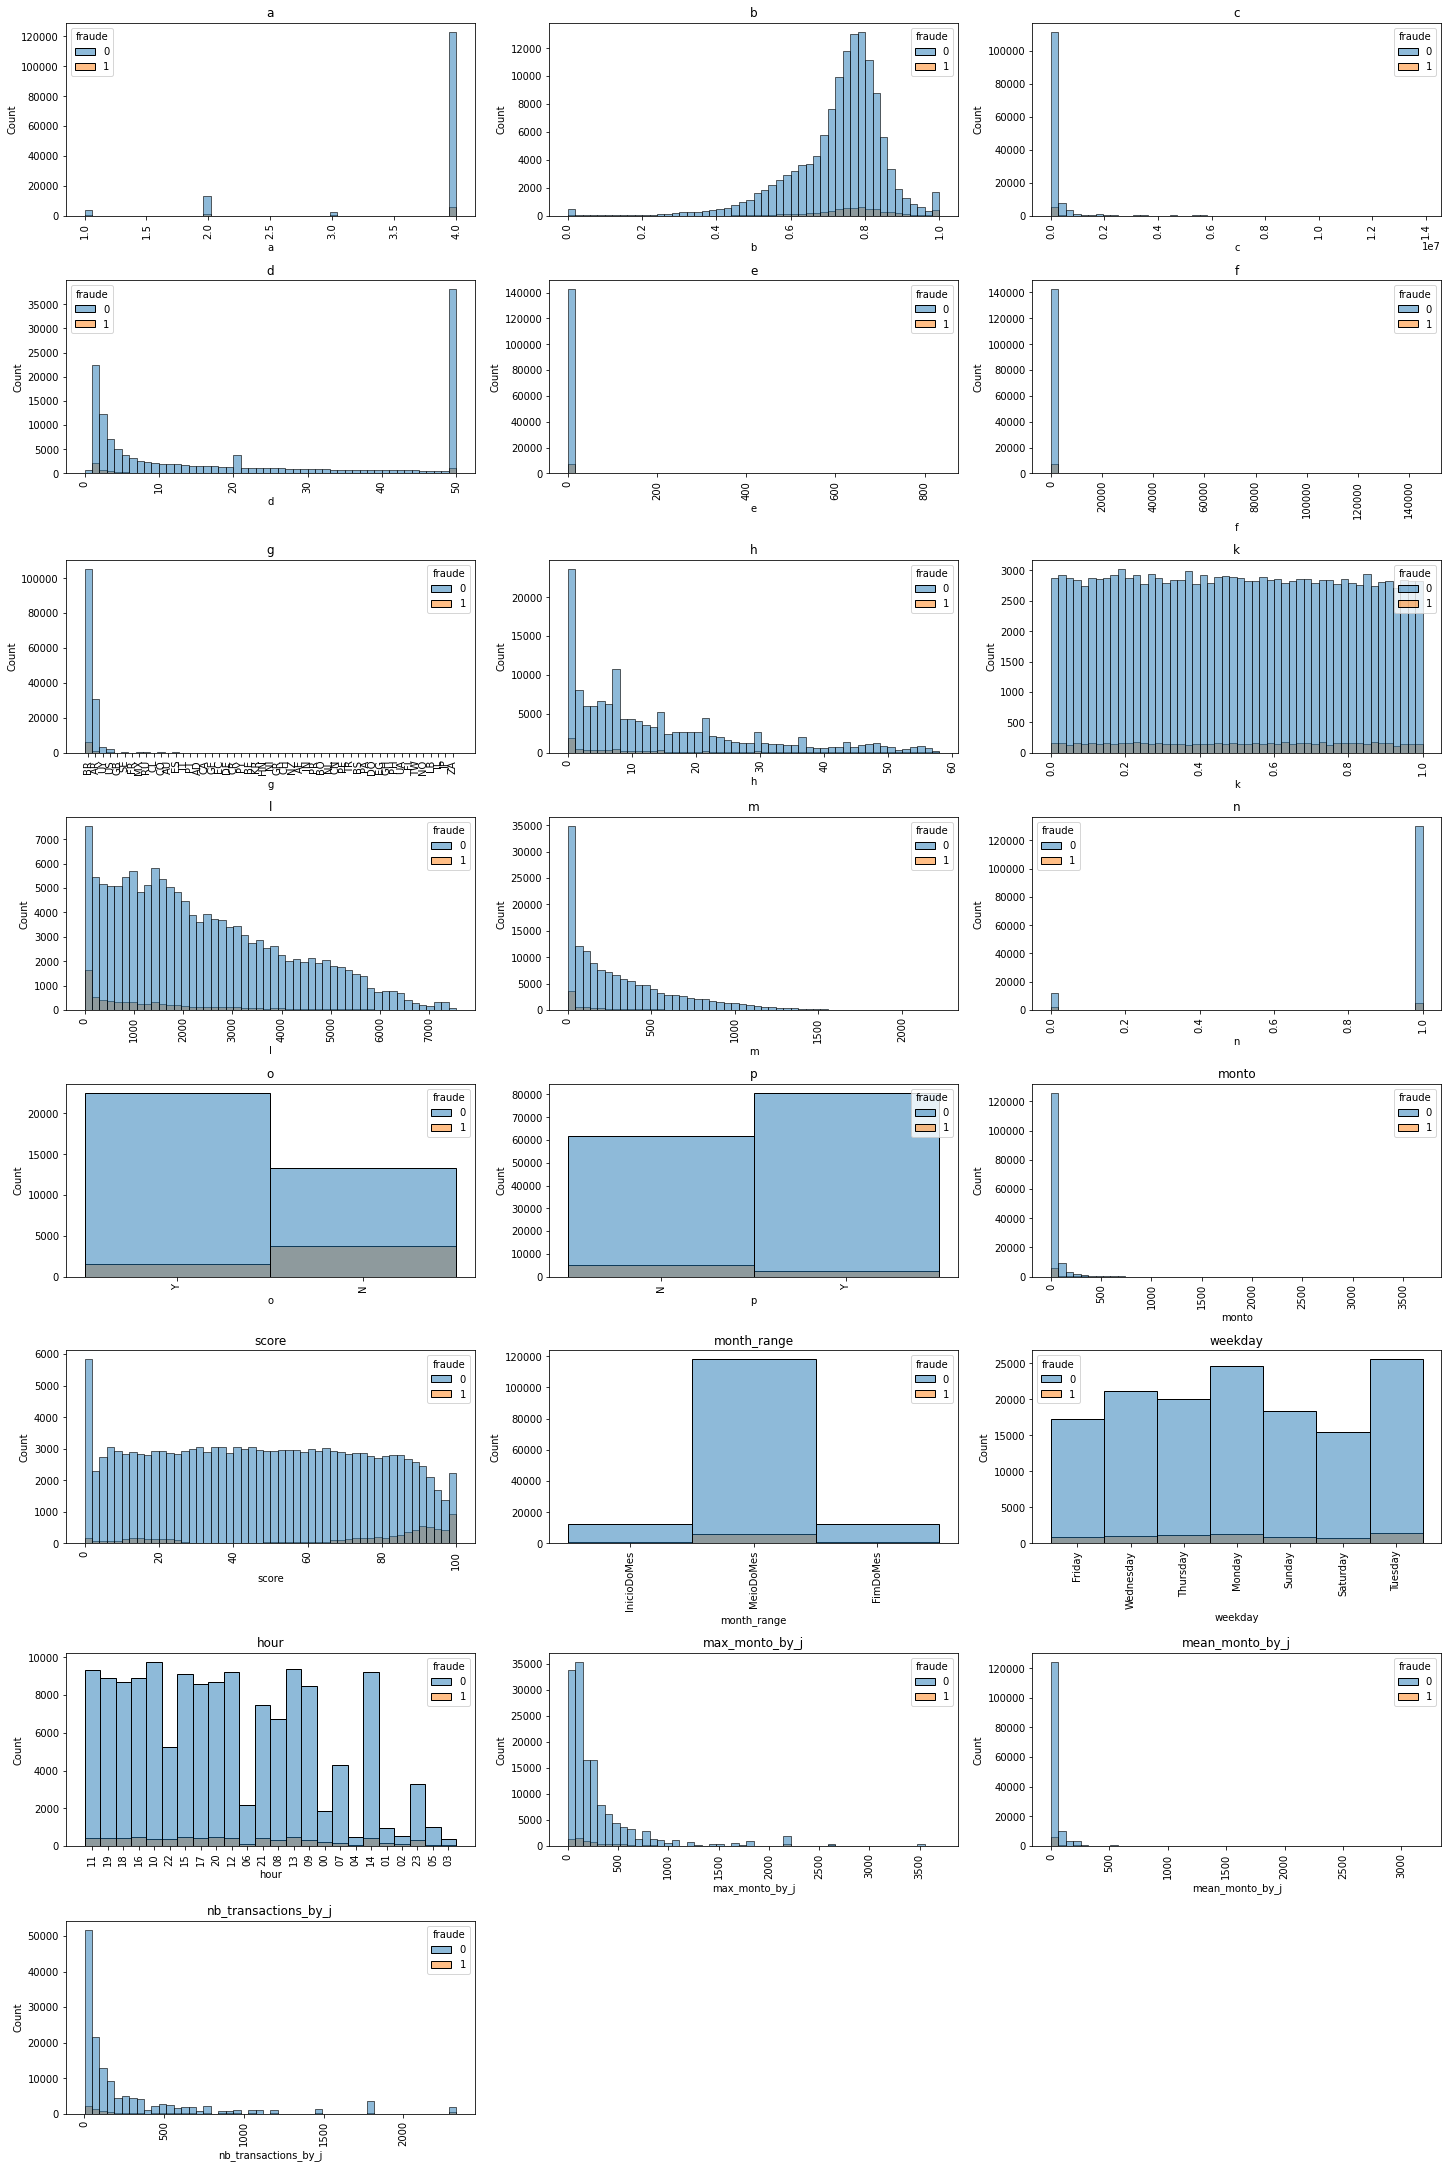

In [84]:
draw_histplots(df[cols_toplot])

E a fraçao de transaçoes fraudulentes por variavel:

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


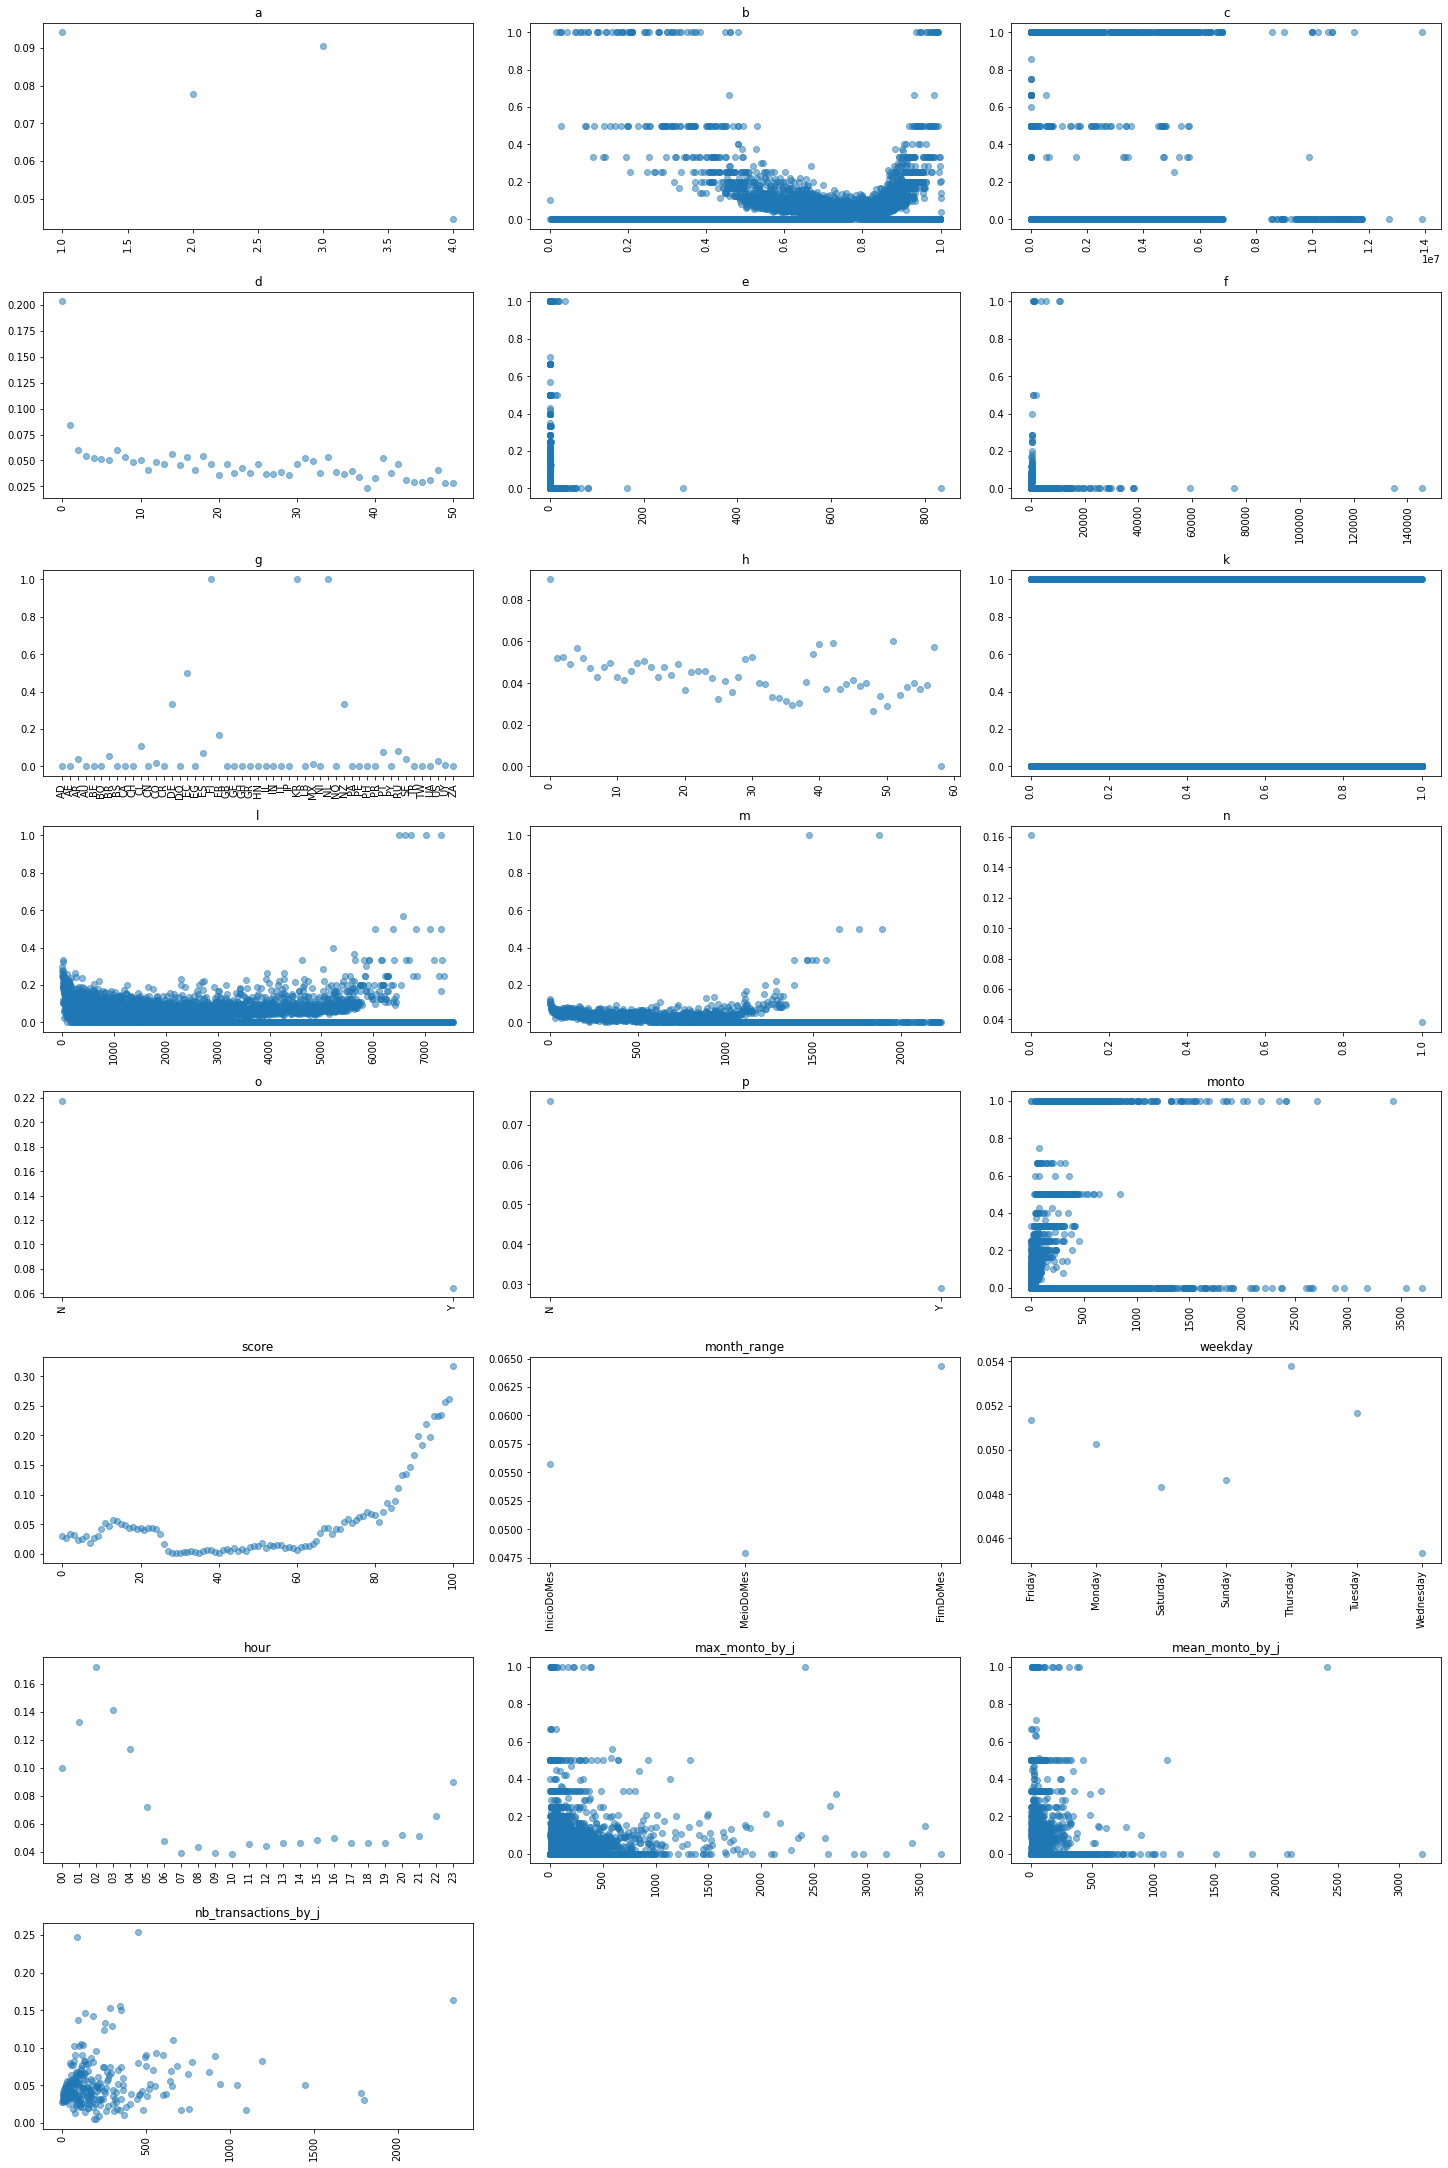

In [85]:
# mean of bin variable = fraction of fraudulent transaction
draw_histplots(df[cols_toplot], gtype="scatter")

- Caso a gente fosse utilizar um modelo de **regressao logistica**, entao poderiamos desconsiderar a variavel `k` pela qual a distribuiçao de fraude parece muita aleatoria. Ou seja, sozinha, a relaçao que ela tem com o target é inexistante. Porem um modelo baseado em arvore poderia eventualmente extrair uma interaçao interessante com outras variaveis.
- Com um **modelo linear**, a gente tambem poderia adicionar a variavel `b` elevada ao quadrado para o algoritmo conseguir extrapolar a relaçao nao linear entre `b` e o target.
- Podemos ver que as informaçoes extraidas do campo `fecha` mostram um relacionamento forte com o target.
  - O inicio e o meio do **mes** sao mais propensos a sofrer com transaçoes fraudulentes.
  - Sobre o dia da **semana**, reparamos um pico de fraudes na quinta, poucas fraudes na quarta, um ritmo de fraudes mais baixo no fim de semana.
  - Temos muito mais fraudes no fim da noite e na madrugada com um pico as **2:00** da manha.
    - Alem de tornar o tipo da variavel `hour` em *integer*, vamos adicionar uma flag binaria `dawn` valendo **1** entre **22:00** e **5:00** da manha e **0** senao para ajudar o modelo na tomada de decisao.

In [ ]:
df['g'].unique()

array(['BR', 'AR', 'UY', 'US', 'GB', nan, 'SE', 'FR', 'MX', 'RU', 'CL',
       'CO', 'AU', 'ES', 'IT', 'PT', 'AD', 'CA', 'GE', 'EC', 'DE', 'CR',
       'PY', 'BE', 'KR', 'HN', 'NI', 'GR', 'CH', 'NZ', 'AE', 'IN', 'PR',
       'BO', 'NL', 'CN', 'PE', 'TR', 'BS', 'PA', 'DO', 'EG', 'GH', 'PH',
       'UA', 'FI', 'TW', 'NO', 'LB', 'IL', 'JP', 'ZA'], dtype=object)

In [ ]:
countries_df = pd.DataFrame()
countries_df["nb_trans"] = df['g'].value_counts()
countries_df["nb_frauds"] = df.loc[df[target_name] == 1, 'g'].value_counts()
countries_df["%frauds"] = countries_df["nb_frauds"] / countries_df["nb_trans"]
countries_df.fillna(0, inplace=True)
countries_df = countries_df[countries_df["nb_frauds"] > 0]

In [ ]:
countries_df

,nb_trans,nb_frauds,%frauds
BR,111628,6162.0,0.055201
AR,31964,1179.0,0.036885
UY,2967,29.0,0.009774
US,2273,70.0,0.030796
SE,358,15.0,0.041899
MX,236,3.0,0.012712
RU,73,6.0,0.082192
ES,69,5.0,0.072464
CO,64,1.0,0.015625
FR,18,3.0,0.166667


In [ ]:
countries_df.sort_values(by="%frauds", ascending=False)

,nb_trans,nb_frauds,%frauds
KR,1,1.0,1.000000
FI,1,1.0,1.000000
NL,2,2.0,1.000000
EC,4,2.0,0.500000
DE,9,3.0,0.333333
NZ,3,1.0,0.333333
FR,18,3.0,0.166667
CL,9,1.0,0.111111
RU,73,6.0,0.082192
PT,13,1.0,0.076923


Percebemos que a taxa de fraude é muito alta para os paises seguintes:
- **KR** - Corea do Sul
- **FI** - Finlândia
- **NL** - Holanda
- **EC** - Equador
- **DE** - Alemanha
- **NZ** - New Zealand
- **FR** - França
- **CL** - Chile

Bem poucas transaçoes tem um desses 8 paise como valor na variavel `g`. A maior parte das transaçoes vem do Brasil, da Argentina, da Uruguay, e dos Estados-Unidos.  
Sabemos que o fraudador pode tentar se esconder atraves de uma **VPN**. Ninguém além do Provedor de **VPN** pode seguir sua atividade na Internet e ninguém vê seu endereço **IP** real. De fato, caso estivermos considerando que o canal de transaçoes é um site de e-commerce, por exemplo, podemos imaginar que as transaçoes desses 8 paises sao feitas pela **VPN** e sao entao bem mais sucetiveis de ser fraudulente. Pois nao precisa de uma **VPN** para entrar num site e realizar uma compra.  

Para refletir a origem duvidosa da transaçao, vamos adicionar uma variavel `country_risk` de categoria com o dominio seguinte:
- **Low** - para os paises Brasil, Argentina, Uruguay, e Estados-Unidos.
- **High** - para os 8 paises os mais duvidosos.
- **Medium** - se for um pais diferente desses 12 paises.  

Mesmo se a nossa hipotese nao fosse valida, o risco de perder dinheiro nao é muito alto, sendo que o modelo vai discriminar paises com um numero muito mais baixo de transaçoes.

# Adiçao de novas variaveis

Depois da visualizaçao das nossas variaveis, decidimos adicionar a nova *feature* `dawn`:

In [86]:
df.loc[:, "hour"] = df["hour"].astype(int)
df.loc[:, "dawn"] = df["hour"].apply(lambda x: 1 if x <= 5 or x >= 22 else 0)

e a nova feature `country_risk`:

In [87]:
low_country_risk = ["BR", "AR", "UY", "US"]
high_country_risk = ["KR", "FI", "NL", "EC", "DE", "NZ", "FR", "CL"]

def map_country_risk(x):
  if x in low_country_risk:
    return "Low"
  if x in high_country_risk:
    return "High"
  return "Medium"

df.loc[:, "country_risk"] = df['g'].apply(lambda x: map_country_risk(x))
df.drop(['g'], axis=1, inplace=True)
df.head()

,a,b,c,d,e,f,h,j,k,l,m,n,o,p,monto,score,fraude,month_range,weekday,hour,max_monto_by_j,mean_monto_by_j,nb_transactions_by_j,dawn,country_risk
0,4,0.7685,94436.24,20.0,0.444828,1.0,5,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,5.64,66,0,FimDoMes,Friday,11,248.12,35.131894,602,0,Low
1,4,0.7550,9258.50,1.0,0.000000,33.0,0,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,124.71,72,0,MeioDoMes,Wednesday,19,757.46,33.224759,187,0,Low
2,4,0.7455,242549.09,3.0,0.000000,19.0,23,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,339.32,95,0,MeioDoMes,Wednesday,18,929.21,250.421304,69,0,Low
3,4,0.7631,18923.90,50.0,0.482385,18.0,23,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,3.54,2,0,MeioDoMes,Thursday,16,58.12,9.342903,31,0,Low
4,2,0.7315,5728.68,15.0,0.000000,1.0,2,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,3.53,76,0,InicioDoMes,Thursday,10,254.36,14.462588,1449,0,Low


# Limpeza dos dados

## Impute dos valores null

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   a                     150000 non-null  int64   
 1   b                     137016 non-null  float64 
 2   c                     137016 non-null  float64 
 3   d                     149635 non-null  float64 
 4   e                     150000 non-null  float64 
 5   f                     149989 non-null  float64 
 6   h                     150000 non-null  int64   
 7   j                     150000 non-null  object  
 8   k                     150000 non-null  float64 
 9   l                     149989 non-null  float64 
 10  m                     149635 non-null  float64 
 11  n                     150000 non-null  int64   
 12  o                     41143 non-null   object  
 13  p                     150000 non-null  object  
 14  monto                 150000 non-nul

A variavel `o` tem muitos valores null. Mas nao podemos desconsiderar ela por causa da forte relaçao que ela tem com o target.  
Vamos imputar os valores null com o valor "*Unknown*".

In [89]:
df.loc[:, "o"] = df["o"].fillna("Unknown")

In [90]:
df[df[target_name] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 16 to 149985
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   a                     7500 non-null   int64   
 1   b                     6671 non-null   float64 
 2   c                     6671 non-null   float64 
 3   d                     7471 non-null   float64 
 4   e                     7500 non-null   float64 
 5   f                     7500 non-null   float64 
 6   h                     7500 non-null   int64   
 7   j                     7500 non-null   object  
 8   k                     7500 non-null   float64 
 9   l                     7500 non-null   float64 
 10  m                     7471 non-null   float64 
 11  n                     7500 non-null   int64   
 12  o                     7500 non-null   object  
 13  p                     7500 non-null   object  
 14  monto                 7500 non-null   float64 
 15  s

Entre as transaçoes fraudulentes, tem variaveis com valores null.  
Ou seja, nao podemos considerar o **listwise deletion** para nao correr o risco de perder registros de fraudes, que estao em quantidade reduzida.

Vamos imputar os valores null da seguinte forma:
- as variaveis de tipo *float* cujam nao temos a definiçao: imputamos pelo valor *mode*, robusto aos potenciais *outliers*.
- So um valor de tipo string, `g`, esta com valores null. Essa coluna é provavelmente a sigla do pais da pessoa que fez a transaçao. Podemos tambem substituir os valores null pela sigla do pais o mais comum do *dataset*, o **Brasil**. 

In [91]:
# we include n and p in case these columns have null values on new unseen data
# they're variable with binary values, like o, so we cannot substitute with mode value
no_impute = [old_res, target_name, 'n', 'o', 'p', "month_range", "weekday", "hour"]
to_impute = [col for col in df.columns if col not in no_impute]

In [92]:
d_modes = dict()
d_modes['n'] = "Unknown"
d_modes['o'] = "Unknown"
d_modes['p'] = "Unknown"

for col in to_impute:
  d_modes[col] = df[col].mode()[0]

In [93]:
df.fillna(d_modes, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   a                     150000 non-null  int64   
 1   b                     150000 non-null  float64 
 2   c                     150000 non-null  float64 
 3   d                     150000 non-null  float64 
 4   e                     150000 non-null  float64 
 5   f                     150000 non-null  float64 
 6   h                     150000 non-null  int64   
 7   j                     150000 non-null  object  
 8   k                     150000 non-null  float64 
 9   l                     150000 non-null  float64 
 10  m                     150000 non-null  float64 
 11  n                     150000 non-null  int64   
 12  o                     150000 non-null  object  
 13  p                     150000 non-null  object  
 14  monto                 150000 non-nul

# Avaliaçao do algoritmo antigo

Nao temos como saber se o modelo antigo foi treinado com dados desse dataset. Por isso o resultado da avaliaçao pode ser enviesado.  
Vamos avaliar o **poder discriminativo** do algoritmo usando a metrica **AUC**.

In [ ]:
from sklearn.metrics import roc_auc_score

print("AUC on full dataset: ", 
      roc_auc_score(
          df["fraude"], 
          df[old_res] * 0.01))

AUC on full dataset:  0.726275487251462


Esse resultado do modelo antigo servira de baseline nas nossas proximas analises.

# Modelagem

Concatenamos os nossos preprocessamentos na funçao `preprocess_pipeline`:

In [94]:
import pandas as pd
import numpy as np
import datetime

target_name = "fraude"
old_res = "score"

map_weekday = {0: "Monday",
               1: "Tuesday",
               2: "Wednesday",
               3: "Thursday",
               4: "Friday",
               5: "Saturday",
               6: "Sunday"}

low_country_risk = ["BR", "AR", "UY", "US"]
high_country_risk = ["KR", "FI", "NL", "EC", "DE", "NZ", "FR", "CL"]

def map_country_risk(x):
  if x in low_country_risk:
    return "Low"
  if x in high_country_risk:
    return "High"
  return "Medium"

def preprocess_pipeline(df, aggr_lookup):
	# drop purchase descriptions
	df.drop(['i'], axis=1, inplace=True)

	# date transformations
	df.loc[:, "date"] = df["fecha"].str.split().apply(lambda x: x[0])
	df.loc[:, "time"] = df["fecha"].str.split().apply(lambda x: x[1])

	bins = [-np.inf, 5, 25, np.inf]
	labels = ["InicioDoMes", "MeioDoMes", "FimDoMes"]
	df.loc[:, "month_range"] = pd.cut(
		df["date"].str.split('-').apply(lambda x: int(x[-1])),
		bins=bins,
		labels=labels
	)

	df.loc[:, "weekday"] = df["date"].str.split('-').apply(
		lambda x: map_weekday[datetime.datetime(int(x[0]), int(x[1]), int(x[2])).weekday()]
	)
	df.loc[:, "hour"] = df["time"].str.split(':').apply(lambda x: x[0])
	df.drop(["fecha", "date", "time"], axis=1, inplace=True)

	# aggregations
	# reset_index and set_index is to keep same index as input DataFrame
	df = df.reset_index().merge(
		df[['j', "monto"]].groupby('j').max().rename(columns={"monto":"max_monto_by_j"}),
		on='j',
		how="left"
	).set_index('index')

	df = df.reset_index().merge(
		df[['j', "monto"]].groupby('j').mean().rename(columns={"monto":"mean_monto_by_j"}),
		on='j',
		how="left"
	).set_index('index')

	df = df.reset_index().merge(
		df.groupby('j').size().rename("nb_transactions_by_j"),
		on='j',
		how="left"
	).set_index('index')

	# remove j identifier
	df.drop('j', axis=1, inplace=True)

	# new feature dawn
	df.loc[:, "hour"] = df["hour"].astype(int)
	df.loc[:, "dawn"] = df["hour"].apply(lambda x: 1 if x <= 5 or x >= 22 else 0)

	# new feature country_risk
	df.loc[:, "country_risk"] = df['g'].apply(lambda x: map_country_risk(x))
	df.drop(['g'], axis=1, inplace=True)

	# imputing null values
	no_impute = [old_res, target_name, 'n', 'o', 'p', "month_range", "weekday", "hour"]
	to_impute = [col for col in df.columns if col not in no_impute]

	d_modes = dict()
	d_modes['n'] = "Unknown"
	d_modes['o'] = "Unknown"
	d_modes['p'] = "Unknown"

	for col in to_impute:
		d_modes[col] = df[col].mode()[0]

	df.fillna(d_modes, inplace=True)
	return df

In [95]:
df = pd.read_csv('/content/drive/MyDrive/MELI/data/dados.csv', sep=',')
y = df[target_name]
X = df.drop([target_name, old_res], axis=1)

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [97]:
aggr_lookup = X_train.groupby('j').size().rename("nb_transactions_by_j")

X_train = preprocess_pipeline(X_train.copy(), aggr_lookup)
X_train.head()

,a,b,c,d,e,f,h,k,l,m,n,o,p,monto,month_range,weekday,hour,max_monto_by_j,mean_monto_by_j,nb_transactions_by_j,dawn,country_risk
index,,,,,,,,,,,,,,,,,,,,,,
87935,4,0.5669,17231.18,3.0,0.202365,0.0,0,0.648964,2562.0,36.0,1,Unknown,N,8.44,MeioDoMes,Wednesday,17,388.61,23.459940,504,0,Low
3892,4,1.0000,5589970.16,50.0,0.000000,101.0,0,0.874316,4892.0,993.0,1,Unknown,Y,36.59,MeioDoMes,Friday,17,92.68,34.333077,13,0,Low
41404,4,0.9019,4520525.44,31.0,0.000000,23.0,17,0.215172,704.0,290.0,1,Unknown,Y,114.19,InicioDoMes,Thursday,16,2174.06,253.423981,1570,0,Low
91124,4,0.8363,22234.24,1.0,0.617241,-1.0,22,0.399146,2362.0,171.0,1,Y,Y,5.53,MeioDoMes,Thursday,10,120.99,9.041930,627,0,Low
67372,4,0.7793,55084.77,2.0,0.000000,8.0,11,0.614409,1600.0,62.0,1,Unknown,N,124.35,MeioDoMes,Saturday,11,755.46,225.404815,27,0,Low


In [98]:
to_encode = ['o', 'p', 'month_range', 'weekday', 'country_risk']
# drop_first=False for interpretation
X_train_encoded = pd.get_dummies(data=X_train, columns=to_encode, drop_first=False)
X_train_encoded.head()

,a,b,c,d,e,f,h,k,l,m,n,monto,hour,max_monto_by_j,mean_monto_by_j,nb_transactions_by_j,dawn,o_N,o_Unknown,o_Y,p_N,p_Y,month_range_InicioDoMes,month_range_MeioDoMes,month_range_FimDoMes,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,country_risk_High,country_risk_Low,country_risk_Medium
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87935,4,0.5669,17231.18,3.0,0.202365,0.0,0,0.648964,2562.0,36.0,1,8.44,17,388.61,23.459940,504,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
3892,4,1.0000,5589970.16,50.0,0.000000,101.0,0,0.874316,4892.0,993.0,1,36.59,17,92.68,34.333077,13,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0
41404,4,0.9019,4520525.44,31.0,0.000000,23.0,17,0.215172,704.0,290.0,1,114.19,16,2174.06,253.423981,1570,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0
91124,4,0.8363,22234.24,1.0,0.617241,-1.0,22,0.399146,2362.0,171.0,1,5.53,10,120.99,9.041930,627,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0
67372,4,0.7793,55084.77,2.0,0.000000,8.0,11,0.614409,1600.0,62.0,1,124.35,11,755.46,225.404815,27,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [99]:
# same operations on test set
X_test = preprocess_pipeline(X_test.copy(), aggr_lookup)

# drop_first=False for interpretation
X_test_encoded = pd.get_dummies(data=X_test, columns=to_encode, drop_first=False)

In [100]:
from sklearn.metrics import roc_auc_score

def print_scores(y, predictions):
    print("ROC AUC score:", roc_auc_score(y, predictions))

Nao é um problema de inferencia. O nosso objetivo neste primeiro tempo é implementar um modelo com o maior poder preditivo possivel.  
Usaremos modelos baseados em arvores por eles serem nao lineares, nao sensíveis aos outliers e a escala das variaveis.

Alem disso 
- os modelos baseados em arvores permitem implementar a estratégia de **Sensitive Learning** com o parâmetro `class weight` da biblioteca `scikit-learn` para lidar com o **problema de balanceamento** das classes positivas e negativas.
- Eles tambem implementam uma funcionalidade de seleçao de variaveis `embedded`:
  - as variaveis sao naturalmente classificadas dependendo do quão bem elas melhoram a pureza do nó.

Neste primeiro tempo, usaremos o modelo de foresta aleatoria da biblioteca *scikit-learn* ajustando os pesos do algoritmos de 2 formas a partir do hiperparametro `class_weight`:
- usando o valor `balanced`:
  - usa os valores de `y` para ajustar automaticamente os pesos inversamente proporcionais às frequências da classe nos dados de entrada;
- usando o valor `balanced_subsample`:
  - o mesmo, exceto que os pesos são calculados novamente a cada iteração de crescimento de uma árvore na floresta aleatória.

In [101]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_estimators=100, max_depth=6, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

print("Test on training set")
print_scores(y_train, rf.predict_proba(X_train_encoded)[:,1])

print("Test on test set")
print_scores(y_test, rf.predict_proba(X_test_encoded)[:,1])

Test on training set
ROC AUC score: 0.8496837264878311
Test on test set
ROC AUC score: 0.837961521674941


In [102]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced_subsample", n_estimators=100, max_depth=6, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

print("Test on training set")
print_scores(y_train, rf.predict_proba(X_train_encoded)[:,1])

print("Test on test set")
print_scores(y_test, rf.predict_proba(X_test_encoded)[:,1])

Test on training set
ROC AUC score: 0.8496387736220157
Test on test set
ROC AUC score: 0.8379728074336218


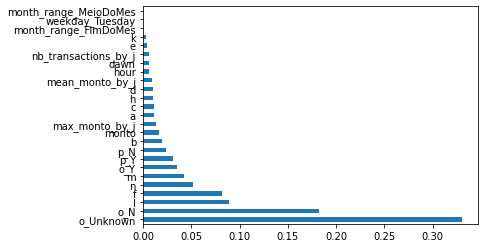

In [103]:
import matplotlib.pyplot as plt

# plot most important variables
feat_importances = pd.Series(
    rf.feature_importances_, 
    index=X_train_encoded.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

- As variaveis fornecidas, `o`, `f`, `l`, `n`, `m`, `p`, etc ja ajudam bastante na reduçao da impureza nos *splits* dos arvores. 
- De fato, as informaçoes que extraimos e as variaveis que adicionamos nao aparecem como as mais importantes.
- Mas mesmo assim, é importante ter essas novas variaveis como recurso para utilizar, caso a gente nao tenha as principais variaveis disponiveis na hora da prediçao.

Testamos aqui com o modelo de **gradient boost**.  
Esse modelo utiliza arvores. A cada iteração, o novo preditor recebe como input os erros residuais dos resultados do preditor anterior.  
Vamos utilizar uma versão melhorada do **gradient boost**: `XGBoost`, mais regularizada, a fim de minimizar o overfit.

In [104]:
from xgboost import XGBClassifier

clf = XGBClassifier(scale_pos_weight=80)
clf.fit(X_train_encoded, y_train)

print("Test on training set")
print_scores(y_train, clf.predict_proba(X_train_encoded)[:,1])

print("Test on test set")
print_scores(y_test, clf.predict_proba(X_test_encoded)[:,1])

Test on training set
ROC AUC score: 0.8602622955052757
Test on test set
ROC AUC score: 0.8435244021173495


Conseguimos um melhor resultado no set de teste.  
Vamos utilizar a **validaçao cruzada** para reforçar a nossa hipotese que o `XGBoost` tem um maior poder de discriminaçao que as 2 outras configuraçoes de modelo. 

In [105]:
models = []
models.append(('RF balanced', RandomForestClassifier(random_state=42, class_weight="balanced", n_estimators=100, max_depth=6, n_jobs=-1)))
models.append(('RF balanced_subsample', RandomForestClassifier(random_state=42, class_weight="balanced_subsample", n_estimators=100, max_depth=6, n_jobs=-1)))
models.append(('XGB scale_pos_weight 80', XGBClassifier(scale_pos_weight=80, n_jobs=-1)))


In [106]:
from sklearn.model_selection import KFold, cross_val_score

num_folds = 10
scoring = 'roc_auc'
seed = 42

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train_encoded, y_train, cv=kfold, \
      scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF balanced: 0.837993 (0.010582)
RF balanced_subsample: 0.837995 (0.010639)
XGB scale_pos_weight 80: 0.842971 (0.010844)


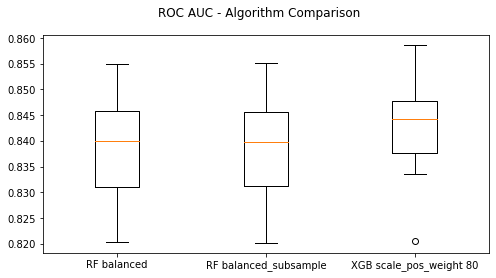

In [107]:
# compare algorithms
fig = plt.figure()
fig.suptitle('ROC AUC - Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
plt.show()

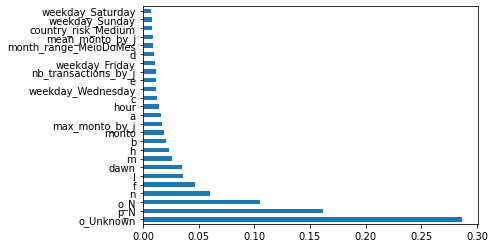

In [108]:
# plot most important variables
feat_importances = pd.Series(
    clf.feature_importances_, 
    index=X_train_encoded.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

O `XGBoost` conseguiu tirar vantagem de mais variaveis *engineered* nas etapas anteriores: `dawn`, `hour`, `month_range`, etc.

Conseguimos um novo modelo com bem mais poder discriminativo que o modelo antigo (**AUC** de 0.73 no dataset inteiro).

**Obs.**: Uma proxima étapa deveria ser a otimizaçao dos hiperparametros utilizando a biblioteca `hyperopt` (otimizaçao baiesiana), por exemplo. Mas eu vou pular essa etapa para nao ter que esperar 2 horas. O ganho tambem nao costuma ser tao significativo.

# Questoes do case

## 1 e 2

ja respondidas.

## 3.

**Como você pode garantir que o desempenho do modelo no laboratório vai ser um proxy para o desempenho do modelo em produção?**

- Avaliar o modelo no set de teste
  - sao dados que o modelo nao utilizou na fase de treinamento/validaçao. Ou seja, ja da mais confiança na capacidade de generalizaçao do modelo.
- Porem isso nao resolve o problema. O ideal é de monitorar o mais rapido possivel o novo modelo em produçao em amostras representativas da populaçao para diminuir o risco de afetar negativamente os clientes e a empresa.
  - Em paralelo, deixamos o modelo antigo executando e monitoramos tambem as performancias dele. So a partir do momento que temos a confiança necessaria que o novo modelo ultrapassa o modelo antigo, que podemos atualizar o modelo em produçao.

## 4.

**Supondo que o desempenho produtivo seja muito diferente do esperado,
quais você acha que são as causas mais prováveis?**

- Os dados do treinamento podem ser desatualizadas;
  - neste caso, teriamos que solicitar dados mais atualizados pro time de ingestao.
- Algumas das variaveis do set de treinamento podem ter causado *data leakage*;
  - Como nao temos a dicionarizaçao das variaveis, é dificil saber se esses dados nao capturaram alguma informaçao pos prediçao, por exemplo.
    - Caso nao for possivel obter essa dicionarizaçao, podemos tentar remover as variaveis de maior importancia na fase de treinamento e testar nos dados produtivos mais recente se isso melhora ou nao a performancia.
- Alem dessas causas mais provaveis, podemos investigar outras hipoteses, como:
  - aconteceu algum problema tecnico no pipeline de engenheira de dados recentemente?
  - Como foi feita a labelizaçao do set de treinamento? Como os analistas identificam uma fraude exatamente? Esse metodo de identificaçao da fraude é confiavel? Etc.

## 5.

**Com a informação adicional de que uma fraude custa 10 vezes mais para a
empresa do que o bloqueio incorreto de um pagamento, o que você faria de diferente?**

$custo(FN) = 10 \times custo(FP)$

Temos que calibrar o modelo para minimizar o custo final.

## 6.

**Queremos encontrar o ponto de corte ideal para o modelo já treinado
apresentado na parte (Score, onde 0 (zero) é o risco mais baixo e 100 (cem) o
mais alto).**   
- **Sabemos que MELI ganha 10% do valor de um pagamento aprovado corretamente 
e a cada fraude aprovada perdemos 100% do valor do pagamento.** 

**Defina o ponto de corte que maximize os lucros do MELI, de forma que todos os pagamentos com menor Score sejam aprovados e os maiores sejam rejeitados.**

Vamos supor o seguinte:
- Valor medio da transaçao: $V = 500$ reais
- A MELI ganha uma taxa de **0.10** em cada pagamento aprovado.
- **TN** - cada **verdadeiro negativo** faz ganhar $V \times 0.10$
- **TP** - podemos imaginar que nao tem custo operacional, ja que o bloqueio da transaçao é automatizado. Entao cada **verdadeiro positivo** salva o custo de uma fraude.
- **FP** - **falso positivo** (perdemos $V \times 0.10$, o dinheiro que poderiamos ter ganhado com a taixa na transaçao).
- **FN** - cada **falso negativo** faz perder $9 \times V \times 0.10 = 0.9 \times V$ (e perdemos tambem $V \times 0.10$, o dinheiro que poderiamos ter ganhado com a taixa na transaçao. Ou seja, no total, perdemos $10 \times V \times 0.10$ que corresponde a 10 vezes mais do que um **falso positivo**)  

Dessa forma, vamos tentar maximizar a funçao de lucro final:  
$TN - FN \times 9$

In [109]:
# we have to maximize TN - FN * 9
def max_fun(nb_TNs, nb_FNs):
    return nb_TNs - nb_FNs * 9

# get the strategy that maximizes the precedent funcion
def get_strategy_table_TN_FN_MaxFun(model, X_test, y_test, max_fun):
    """
        - the acceptance rate here is the percentage of as non fraud considered transactions
    """
    preds_df = pd.DataFrame()
    preds_df['prob_fraud'] = model.predict_proba(X_test)[:,1]
    preds_df['pred_fraud'] = model.predict(X_test)
    preds_df['true_fraud'] = np.ravel(y_test)
    
    accept_rates = np.arange(0.05, 1.05, 0.05)
    
    ## Making the strategy table
    # Populate the arrays for the strategy table with a for loop
    thresholds = []
    
    TNs = []
    FNs = []
    to_maximize = []
    for rate in accept_rates:
        # Calculate the threshold for the acceptance rate
        thresh = np.quantile(preds_df['prob_fraud'], rate).round(3)
        # Add the threshold value to the list of thresholds
        thresholds.append(np.quantile(preds_df['prob_fraud'], rate).round(3))
        # Reassign the loan_status value using the threshold
        preds_df['pred_fraud'] = preds_df['prob_fraud'].apply(lambda x: 1 if x > thresh else 0)
        
        TN = preds_df[(preds_df['pred_fraud'] == 0) & (preds_df['true_fraud'] == 0)]
        FN = preds_df[(preds_df['pred_fraud'] == 0) & (preds_df['true_fraud'] == 1)]
        
        nb_TNs = len(TN)
        nb_FNs = len(FN)
        TNs.append(nb_TNs)
        FNs.append(nb_FNs)

        to_maximize.append(max_fun(nb_TNs, nb_FNs))

    # Create a data frame of the strategy table
    strat_df = pd.DataFrame(zip(accept_rates, thresholds, TNs, FNs, to_maximize),
                            columns = ['Acceptance Rate','Threshold','TNs', 'FNs', 'To Maximize'])
    
    # Print the entire table
    print(strat_df)
    row_max_estimated_value = strat_df.loc[strat_df['To Maximize'] == strat_df['To Maximize'].max()]
    max_benef_threshold = np.ravel(row_max_estimated_value['Threshold'])[0] 
    return preds_df, strat_df, row_max_estimated_value, max_benef_threshold

In [110]:
preds_df, strat_df, row_max_estimated_value, max_benef_threshold = get_strategy_table_TN_FN_MaxFun(clf, X_test_encoded, y_test, max_fun)

    Acceptance Rate  Threshold    TNs   FNs  To Maximize
0              0.05      0.245   2462     3         2435
1              0.10      0.292   4931    13         4814
2              0.15      0.330   7415    27         7172
3              0.20      0.364   9840    48         9408
4              0.25      0.401  12321    62        11763
5              0.30      0.438  14731    82        13993
6              0.35      0.475  17175   111        16176
7              0.40      0.511  19624   150        18274
8              0.45      0.549  22103   188        20411
9              0.50      0.586  24500   223        22493
10             0.55      0.626  26975   276        24491
11             0.60      0.667  29344   338        26302
12             0.65      0.712  31734   407        28071
13             0.70      0.757  34157   492        29729
14             0.75      0.798  36471   611        30972
15             0.80      0.838  38821   753        32044
16             0.85      0.873 

In [111]:
X_test_encoded[y_test == 1].shape

(2470, 35)

In [112]:
print(row_max_estimated_value)

    Acceptance Rate  Threshold    TNs   FNs  To Maximize
17              0.9      0.908  43370  1179        32759


Para o nosso novo modelo, com um bloqueio de transaçao em **10** porcentos da populaçao, para um threshold de **0.908**, conseguimos maximizar o nosso lucro, deixando passar **1179** fraudes, o que corresponde a **48** porcentos do nosso total de fraudes.

In [113]:
class OldClf:
    def __init__(self):
        pass
    def predict_proba(self, X):
        probs = X[old_res] * 0.01
        return np.column_stack(([1 - probs, probs]))
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

In [114]:
old_clf = OldClf()
preds_df, strat_df, row_max_estimated_value, max_benef_threshold = get_strategy_table_TN_FN_MaxFun(old_clf, df, df[target_name], max_fun)

    Acceptance Rate  Threshold     TNs   FNs  To Maximize
0              0.05       0.03    8112   256         5808
1              0.10       0.08   15368   439        11417
2              0.15       0.13   22540   782        15502
3              0.20       0.18   29657  1146        19343
4              0.25       0.23   36879  1464        23703
5              0.30       0.28   44149  1604        29713
6              0.35       0.33   51552  1621        36963
7              0.40       0.38   59097  1654        44211
8              0.45       0.43   66586  1689        51385
9              0.50       0.48   74095  1749        58354
10             0.55       0.53   81434  1851        64775
11             0.60       0.58   88835  1944        71339
12             0.65       0.63   96186  2024        77970
13             0.70       0.68  103532  2265        83147
14             0.75       0.73  110708  2609        87227
15             0.80       0.78  117649  3058        90127
16            

In [115]:
print(row_max_estimated_value)

    Acceptance Rate  Threshold     TNs   FNs  To Maximize
16             0.85       0.83  123207  3440        92247


Para o nosso modelo antigo, aplicado ao *dataset* completo, com um bloqueio em **15** porcentos das transaçoes, para um threshold de **0.83**, conseguimos maximizar o nosso lucro, deixando passar **3440** fraudes, o que corresponde a **46** porcentos do nosso total de fraudes.

O nosso novo modelo conseguiu bloquear **2 porcentos** de fraudes a mais com menos transaçoes bloqueadas.  
O nosso ponto de corte com o modelo antigo seria o threshold **0.83**:

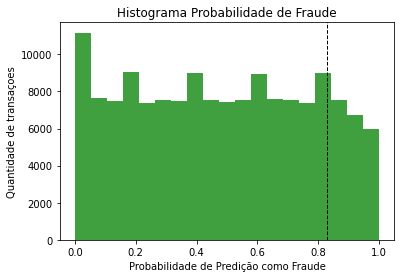

Threshold de lucro maximo: 0.83


In [116]:
# Plot a histogram of the prediction probability
plt.hist(old_clf.predict_proba(df)[:, 1], 19, density=False, facecolor='g', alpha=0.75)
plt.axvline(max_benef_threshold, color='k', linestyle='dashed', linewidth=1)

plt.xlabel('Probabilidade de Predição como Fraude')
plt.ylabel('Quantidade de transaçoes')
plt.title('Histograma Probabilidade de Fraude')

# Show the plot
plt.show()
print("Threshold de lucro maximo:", max_benef_threshold)

Ou seja, bloqueamos todas as transaçoes com uma probabilidade de ser fraude maior que **0.83**.

## 7.

**Se o modelo precisar responder online, no menor tempo possível, o que isso
mudaria suas decisões no item 1?**

- Tempo de prediçao da **regressao logistica**: $O(d + k)$
    - O tempo de prediçao de **regressão logística** é linear tanto no número de pontos de dados quanto na quantidade de variaveis.
- Tempo de prediçao do **Gradient Boost**: $O(2mt)$  
    - O tempo de prediçao do **GBT** é linear no tamanho dos dados e no tamanho do modelo ($t$ árvores, cada uma com no máximo $2 m$ de folhas, onde $m$ é a profundidade máxima da árvore).
        - Com menos variaveis, podemos deixar o modelo mais simples com menos folhas e uma profundidade reduzida.

Ou seja, o ideal para otimizar o tempo de prediçao seria de selecionar menos variaveis. Pra isso, podemos aproveitar da seleçao de features do `XGBoost`. Sendo que ele vai principalmente utilizar as 25 primeiras variaveis para reduzir a impureza nos *splits* dos arvores dele, podemos desconsiderar as outras `features`.  
Alem de aumentar a velocidade da prediçao, a diminuçao da quantidade de variaveis deixa a debugagem, a coleta de dados, a engenheiria de dados muito mais simples.


Obviamente, para conseguirmos um tempo de prediçao otimizado, é necessario ter todos os preprocessamentos de dados prontos (`preprocess_pipeline` e encoding das categorias). Ou seja, o ideal seria de deixar os dados preprocessados prontos no banco de dados operacional, a tabela **HBase** por exemplo, e apenas executar a funçao `predict_proba` com o filtro do **threshold** da questao **6**, sempre que o serviço for solicitado.

## 8.

**Como colocar esse modelo em produção?**

Um exemplo de um serviço implementado com **fastapi** para escorragem online com um modelo `XGBoost` no meu repo **GitHub**.  
https://github.com/krzischp/simple_online_ml_model

O ideal é o uso de uma ferramenta como **MLFlow** para centralizar os modelos versionados num repositorio e agilizar o *switch* entre eles, os *experiments* e as comparaçoes de metricas entre cada versao, etc.  
No caso da API **simple_online_ml_model**, o modelo esta salvo no formato **pickle** e é versionado junto com o codigo no **git**.

Essa arquitetura **lambda** simples abaixo permite responder ao problema de prediçao online.  
O serviço final pode chamar a nossa API **simple_online_ml_model** para receber as prediçoes no formato `json`.

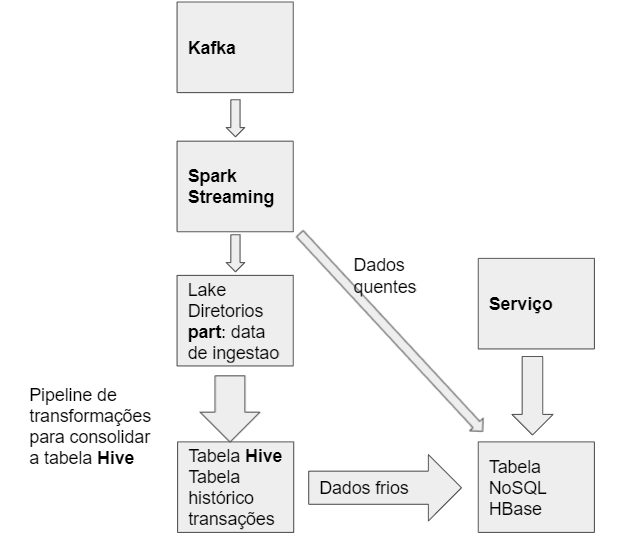

Assim que o modelo for em produçao, nao podemos esquecer de integrar com ferramentas de monitoramento como
- **Amazon SageMaker Model Monitor**
- **Databricks Managed MLFlow**  
para conseguirmos identificar problemas de performancias, *data drift*, etc.